In [36]:
import torch
import dynamiqs as dq
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.ndimage import gaussian_filter, shift
from random import choice

import os
from tqdm import tqdm

dim = 40

xvec = jnp.linspace(-4, 4, 32)
pvec = jnp.linspace(-4, 4, 32)
#grid = jnp.meshgrid(xvec, pvec)

In [37]:
def generate_even_cat_state(alpha=2.0):
    coh = dq.coherent(dim, alpha)
    coh_neg = dq.coherent(dim, -alpha)
    cat = (coh + coh_neg) / jnp.sqrt(2)
    return cat

def generate_odd_cat_state(alpha=2.0):
    coh = dq.coherent(dim, alpha)
    coh_neg = dq.coherent(dim, -alpha)
    cat = (coh - coh_neg) / jnp.sqrt(2)
    return cat

def generate_fock_state(n):
    return dq.fock(dim, n)

def generate_coherent_state(alpha):
    return dq.coherent(dim, alpha)

def evolve_state_with_loss(state, kappa=1.0, t=1.0):
    a = dq.destroy(dim)
    H = 0.0 * a  # trivial Hamiltonian
    result = dq.solve(
        H,
        state,
        t,
        c_ops=[(jnp.sqrt(kappa), a)],
        steps=100,
        solver="me"
    )
    return result.final_state


In [38]:
def add_realistic_noise(wigner, rng=np.random.default_rng(), config=None):
    config = config or {"gaussian_sigma": 1.2, "additive_std": 0.02, "shift_std": 1.0}
    w_noisy = gaussian_filter(wigner, sigma=config["gaussian_sigma"])
    w_noisy += rng.normal(scale=config["additive_std"], size=wigner.shape)
    w_noisy = shift(w_noisy, shift=rng.normal(scale=config["shift_std"], size=2))
    return w_noisy


In [39]:
def generate_dataset_sample(state_type, alpha=2.0, n=None, noise=True):
    if state_type == "even_cat":
        state = generate_even_cat_state(alpha)
    elif state_type == "odd_cat":
        state = generate_odd_cat_state(alpha)
    elif state_type == "fock":
        assert n is not None
        state = generate_fock_state(n)
    elif state_type == "coherent":
        state = generate_coherent_state(alpha)
    else:
        raise ValueError(f"Unknown state type: {state_type}")

    _, _, wigner_clean = dq.wigner(state, xvec=xvec, yvec=pvec)

    if noise:
        wigner_noisy = add_realistic_noise(wigner_clean)
    else:
        wigner_noisy = wigner_clean


    return wigner_noisy, wigner_clean


In [40]:
def plot_wigner_pair(w_clean, w_noisy, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    vmin = min(w_clean.min(), w_noisy.min())
    vmax = max(w_clean.max(), w_noisy.max())

    im0 = axs[0].imshow(w_clean, extent=(-4, 4, -4, 4), origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[0].set_title(f"{title} (clean)")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("p")

    im1 = axs[1].imshow(w_noisy, extent=(-4, 4, -4, 4), origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[1].set_title(f"{title} (noisy)")
    axs[1].set_xlabel("x")

    fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.75)
    plt.tight_layout()
    plt.show()


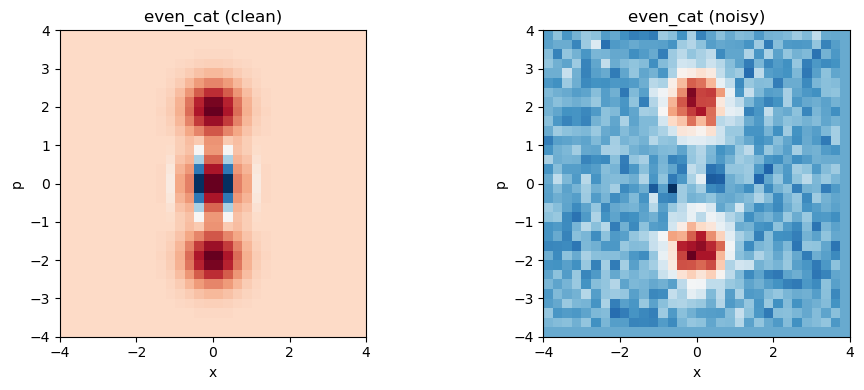

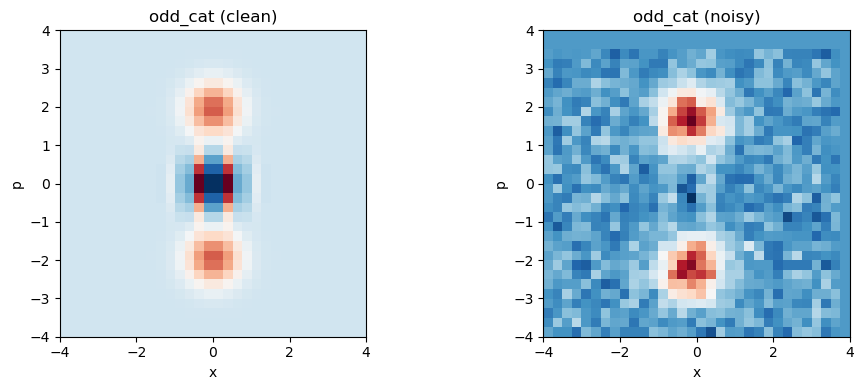

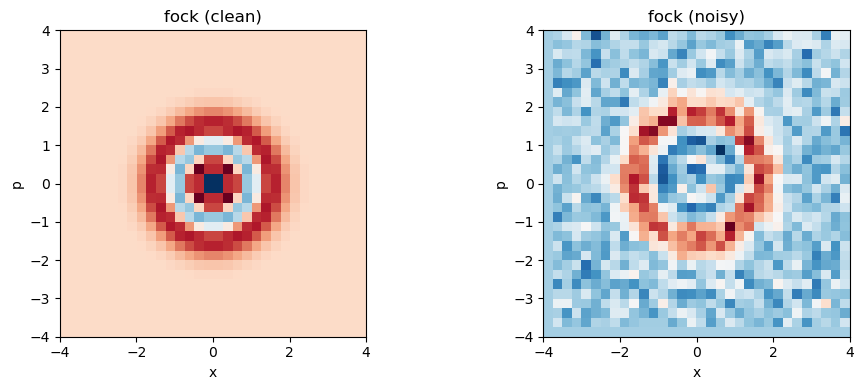

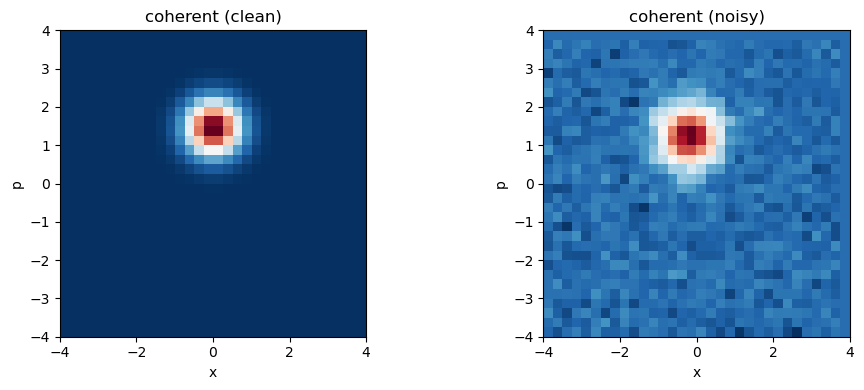

In [41]:
rng = np.random.default_rng(42)

samples_to_plot = [
    ("even_cat", {"alpha": 2.0}),
    ("odd_cat", {"alpha": 2.0}),
    ("fock", {"n": 3}),
    ("coherent", {"alpha": 1.5}),
]

for state_type, params in samples_to_plot:
    w_noisy, w_clean = generate_dataset_sample(
        state_type,
        noise=True,
        **params
    )
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(w_clean, extent=(-4, 4, -4, 4), origin='lower', cmap='RdBu_r')
    plt.title(f"{state_type} (clean)")
    plt.xlabel("x")
    plt.ylabel("p")
    plt.subplot(1, 2, 2)
    plt.imshow(w_noisy, extent=(-4, 4, -4, 4), origin='lower', cmap='RdBu_r')
    plt.title(f"{state_type} (noisy)")
    plt.xlabel("x")
    plt.ylabel("p")
    plt.tight_layout()


In [42]:
from random import choice

state_pool = ["even_cat", "odd_cat", "fock", "coherent"]
weights = [0.3, 0.2, 0.2, 0.3]  # favor cats and coherent

n_samples = 1000
save_path = "wigner_dataset_32/"
os.makedirs(save_path, exist_ok=True)

data = []

for i in tqdm(range(n_samples)):
    state_type = np.random.choice(state_pool, p=weights)
    if state_type in ["even_cat", "odd_cat", "coherent"]:
        alpha = np.random.uniform(1.0, 3.0)
        w_noisy, w_clean = generate_dataset_sample(state_type, alpha=alpha)
    elif state_type == "fock":
        n = np.random.randint(1, 6)
        w_noisy, w_clean = generate_dataset_sample("fock", n=n)

    np.savez_compressed(f"{save_path}/sample_{i}.npz", noisy=w_noisy, clean=w_clean)


100%|██████████| 1000/1000 [00:30<00:00, 33.25it/s]
